/Users/mayafishbach/Desktop/xg_metallicity/delay_times.py:163: RuntimeWarning: invalid value encountered in power
  return np.where((tau > 0) & (tau < cosmo_dict['age_of_universe']/1000), tau**a * np.exp(tau * b), 0)


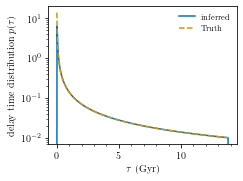

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('/Users/mayafishbach/Desktop/gw-pop-numpyro/src/gw_pop_numpyro/maya.mplstyle')
import seaborn as sns
sns.set_palette("colorblind")

import h5py

import scipy.stats as sss
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz


import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

import numpyro 
from numpyro import distributions as dist, infer
import arviz as az
import corner


from gw_pop_numpyro import cosmo_utils

import delay_times
from delay_times import *

In [2]:
numpyro.set_host_device_count(2)

In [3]:
np.random.seed(213)

In [4]:
npost_draws = 800

In [5]:
cosmo_dict = cosmo_utils.interp_cosmology(zmax = 30)

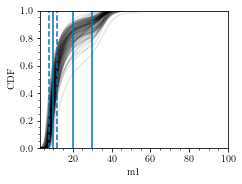

In [6]:
#find "truth" values to make consistent with GWTC-3
#starting with mass distribution

fname = "/Users/mayafishbach/Desktop/gw-pop-numpyro/notebooks/pm1m2_Rz.h5"

with h5py.File(fname, 'r') as inp:
    m1_grid = np.array(inp["m1_grid"])
    m2_grid = np.array(inp["m2_grid"])
    z_grid = np.array(inp["z_grid"])
    pm1m2 = np.array(inp["pm1m2"])
    Rz = np.array(inp["Rz"])
    
pm1 = np.trapz(pm1m2, m2_grid, axis = -1)

cdf_m1 = cumtrapz(pm1, m1_grid, initial = 0)

for i in range(100):
    plt.plot(m1_grid, cdf_m1[i,:], alpha = 0.1, color = 'k')
    
plt.axvline(10)
plt.axvline(8, ls = '--')
plt.axvline(12, ls = '--')
plt.axvline(20)
plt.axvline(30)
    
plt.xlabel('m1')
plt.ylabel('CDF')
plt.xlim(3,100)
plt.ylim(0,1)
plt.show()

In [7]:
#set true parameters for 3 different subpopulations
#60% in pop1, 30% in pop2, 10% in pop3 (at least at z = 0)
#I am now realizing it is confusing to call these pop1-3 because of stars lol

true_params = dict()
true_params["pop1"] = dict()
true_params["pop2"] = dict()
true_params["pop3"] = dict()

true_params["pop1"]["color"] = sns.color_palette()[0]
true_params["pop2"]["color"] = sns.color_palette()[1]
true_params["pop3"]["color"] = sns.color_palette()[2]

true_params["pop1"]["label"] = r"$\mathcal{A}$"
true_params["pop2"]["label"] = r"$\mathcal{B}$"
true_params["pop3"]["label"] = r"$\mathcal{C}$"


true_params["pop1"]["efficiency_func"] = lambda z: 1e-6*np.ones_like(z) #constant efficiency versus redshift

true_params["pop2"]["efficiency_func"] = lambda z: efficiency_versus_redshift(z, wm1 = -0.7, y = 3e-5) #drop off happens at around 0.2 solar metallicity 
true_params["pop3"]["efficiency_func"] = lambda z: efficiency_versus_redshift(z, wm1 = -1, y = 8e-5) #drop off happens at 0.1 solar metallicity 

In [8]:
for key in ["pop1", "pop2", "pop3"]:
    true_params[key]["formation_rate_at_age"] = lambda tau: formation_rate_at_age_func(tau, efficiency_func = true_params[key]["efficiency_func"])



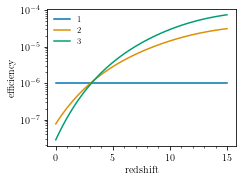

In [9]:
zplot = np.linspace(0, 15, 100)

plt.plot(zplot, true_params["pop1"]["efficiency_func"](zplot), label = '1')
plt.plot(zplot, true_params["pop2"]["efficiency_func"](zplot), label = '2')
plt.plot(zplot, true_params["pop3"]["efficiency_func"](zplot), label = '3')

plt.legend(loc = 'best')
plt.xlabel('redshift')
plt.ylabel('efficiency')
plt.yscale('log')
plt.show()

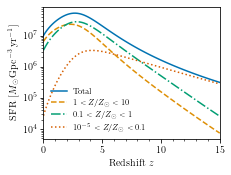

In [10]:
y1 = formation_rate_at_redshift_MD(zplot) * efficiency_versus_redshift_step(zplot, log10Zlow = -5, log10Zhigh = -1, log10Z_grid = np.linspace(-5, 1, 1000))
y2 = formation_rate_at_redshift_MD(zplot) * efficiency_versus_redshift_step(zplot, log10Zlow = -1, log10Zhigh = 0, log10Z_grid = np.linspace(-5, 1, 1000))
y4 = formation_rate_at_redshift_MD(zplot) * efficiency_versus_redshift_step(zplot, log10Zlow = 0, log10Zhigh = 1, log10Z_grid = np.linspace(-5, 1, 1000))

plt.plot(zplot, formation_rate_at_redshift_MD(zplot), label = 'Total')
#plt.plot(test, y1 + y2 + y3 + y4) checked this is equivalent to above
plt.plot(zplot, y4, ls = '--', label = r'$1 < Z / Z_\odot < 10$')
plt.plot(zplot, y2, ls = '-.', label = r'$0.1 < Z/Z_\odot < 1$')
plt.plot(zplot, y1, ls = ':', label = r'$10^{-5} < Z/Z_\odot < 0.1$')

plt.legend(loc = 'best')

plt.yscale('log')
plt.xlim(0,15)

plt.xlabel(r'Redshift $z$')
plt.ylabel(r'SFR [$M_\odot\,\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]')
plt.tight_layout()
#plt.savefig("Figures/SFR_v_redshift_Zbins.pdf")

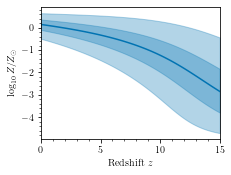

In [11]:
log10Z = np.linspace(-5, 1, 512)
pdflnZ = p_logZ_versus_redshift(log10Z, zplot, alpha = -1.778, mu0 = 0.025, muz = -0.049, omega0 = 1.122, omegaz = 0.049)
lnZ = np.log(10**log10Z * ZSUN)
log10Z_ps = np.zeros((len(zplot),5))
for i, z in enumerate(zplot):
    log10Z_ps[i,:] = interp1d(cumtrapz(pdflnZ, lnZ, axis = -1, initial = 0)[i,:], log10Z)(np.array([0.05, 0.25, 0.5, 0.75, 0.95]))

plt.plot(zplot, log10Z_ps[:,2])
plt.fill_between(zplot, log10Z_ps[:,1], log10Z_ps[:,3], alpha = 0.3, color = sns.color_palette()[0])
plt.fill_between(zplot, log10Z_ps[:,0], log10Z_ps[:,4], alpha = 0.3, color = sns.color_palette()[0])

plt.xlim(0,15)
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'$\log_{10} Z/Z_\odot$')
plt.tight_layout()
#plt.savefig("Figures/metallicity_versus_redshift_model.pdf")

In [12]:
AGE_MIN = (cosmo_dict['age_of_universe'] - cosmo_dict["lookback_time"](15))/1000
print(AGE_MIN)

print((cosmo_dict['age_of_universe'] - cosmo_dict["lookback_time"](30))/1000)

0.26890111547860035
0.09918131546181576


In [13]:
#merger_time_grid = np.linspace(0.01 + AGE_MIN, cosmo_dict['age_of_universe']/1000, 1000) #in Gyr
tau_grid = np.linspace(0.01, cosmo_dict['age_of_universe']/1000, 1000) #in Gyr.
merger_time_grid = tau_grid #grid of merger times has to be same as grid of delay times, but note that the merger rate is zero below AGE_MIN + min(tau_grid) because mergers haven't had time to happen yet

In [14]:
plslope_true = [-1, -0.5, -1]

for i, key in enumerate(["pop1", "pop2", "pop3"]):
    true_params[key]["ptau_grid"] = tau_grid**plslope_true[i]/np.trapz(tau_grid**plslope_true[i], tau_grid) #normalized pdf for delay time distribution



In [15]:
#ptau_grid can be same shape as merger_rate_grid, so set prior on ptau_grid to have same shape as histogram draws

for i, key in enumerate(["pop1", "pop2", "pop3"]):
    prior_plslope = plslope_true[i] + 0.1 * np.random.randn(npost_draws)
    prior_plslope = prior_plslope[np.newaxis,:]
    tau_grid2d = tau_grid[:,np.newaxis]
    norm_fact = np.trapz(tau_grid2d**prior_plslope, tau_grid, axis = 0)
    true_params[key]["ptau_grid_prior"] = tau_grid2d**prior_plslope / norm_fact[np.newaxis,:]

In [16]:
true_params["pop1"]["ptau_grid_prior"].shape

(1000, 800)

In [17]:
for key in ["pop1", "pop2", "pop3"]:

    true_params[key]["merger_rate"] = merger_from_formation_rate_v_age(merger_time_grid, tau_grid, true_params[key]["ptau_grid"], true_params[key]["formation_rate_at_age"])


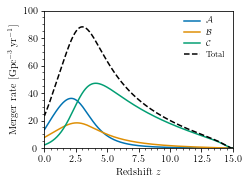

In [18]:
for key in ["pop1", "pop2", "pop3"]:
    plt.plot(redshift_at_age_Gyr(tau_grid), true_params[key]["merger_rate"], color = true_params[key]["color"], label = true_params[key]["label"])
    
total_merger_rate = true_params["pop1"]["merger_rate"] + true_params["pop2"]["merger_rate"] + true_params["pop3"]["merger_rate"]
    
plt.plot(redshift_at_age_Gyr(tau_grid), total_merger_rate , ls = '--', c = 'k', label = 'Total')

plt.xlabel('Redshift $z$')
plt.ylabel(r'Merger rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]')

plt.xlim(0,ZMAX)
plt.ylim(0,100)

plt.legend(loc = 'best')

#plt.grid()

Text(0.5, 0, 'Lookback time')

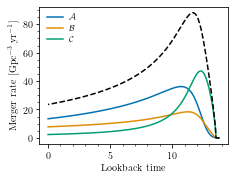

In [19]:
tLs = cosmo_dict["age_of_universe"]/1000 - tau_grid

for key in ["pop1", "pop2", "pop3"]:
    plt.plot(tLs, true_params[key]["merger_rate"], color = true_params[key]["color"], label = true_params[key]["label"])
    
plt.plot(tLs, total_merger_rate, ls = '--', color = 'k')

plt.legend(loc = 'best')

plt.ylabel(r'Merger rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]')
plt.xlabel('Lookback time')

Indeed, locally the first subpopulation makes up 60% of mergers, the second makes up around 30%, and the third makes up around 10%

/var/folders/s1/r51mmkl15w73kqk4mq2jqq5r0000gn/T/ipykernel_70159/2414734166.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(redshift_at_age_Gyr(tau_grid), true_params[key]["merger_rate"]/total_merger_rate)


Text(0, 0.5, 'Fraction of total merger rate')

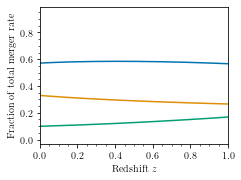

In [20]:
for key in ["pop1", "pop2", "pop3"]:
    plt.plot(redshift_at_age_Gyr(tau_grid), true_params[key]["merger_rate"]/total_merger_rate)

plt.xlim(0,1)
plt.xlabel("Redshift $z$")
plt.ylabel("Fraction of total merger rate")

The (1 + z) evolution slopes are sorta shallow but still ok

(1.0, 60.0)

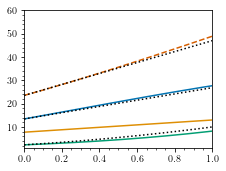

In [21]:
for key in ["pop1", "pop2", "pop3"]:
    plt.plot(redshift_at_age_Gyr(tau_grid), true_params[key]["merger_rate"])
    
plt.plot(redshift_at_age_Gyr(tau_grid), total_merger_rate, ls = '--')


plt.plot(zplot, (1 + zplot)**2.1 * true_params["pop3"]["merger_rate"][-1], ls = ':', c = 'k')
plt.plot(zplot, (1 + zplot)**1 * total_merger_rate[-1], ls = ':', c= 'k')
plt.plot(zplot, (1 + zplot)**1 * true_params["pop1"]["merger_rate"][-1], ls = ':', c= 'k')



plt.xlim(0,1)
plt.ylim(1,60)

### Draw events from each subpopulation

In [22]:

observed = dict()
observed["pop1"] = dict()
observed["pop2"] = dict()
observed["pop3"] = dict()

observed["pop1"]["nevents"] = 18000
observed["pop2"]["nevents"] = 11000
observed["pop3"]["nevents"] = 24000


for key in ["pop1", "pop2", "pop3"]:
    
    observed[key]["zs"], z_grid, true_params[key]["pz"], true_params[key]["merger_rate_grid"], true_params[key]["norm_fact"] = draw_redshifts_from_formation_delay(
        observed[key]["nevents"], merger_time_grid, tau_grid, true_params[key]["ptau_grid"], true_params[key]["formation_rate_at_age"])

In [23]:
##these two arrays have the exact same info, they're just flipped
true_params["pop1"]["merger_rate_grid"] == true_params["pop1"]["merger_rate"][::-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [24]:
for key in ["pop1", "pop2", "pop3"]:
    print(true_params[key]["norm_fact"]) #number of observations in 1 year/ (formation rate at z = 0 in Gpc^-3/yr)
    true_params[key]["Tobs"] = observed[key]["nevents"] / true_params[key]["norm_fact"]

18126.442175137014
10707.400245943752
24170.28386451006


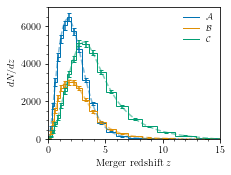

In [25]:
nbins = 20
nhist_draws = npost_draws

logz1bins = np.linspace(np.log(1 + z_grid[0]), np.log(1 + ZMAX), nbins+1)
zbins = np.exp(logz1bins) - 1

logz1bin_centers = 0.5 * (logz1bins[1:] + logz1bins[0:-1])
zbin_centers = np.exp(logz1bin_centers) - 1

logz1bin_width = logz1bins[1:] - logz1bins[0:-1]
zbin_width = zbins[1:] - zbins[0:-1] #this is equivalent to (1 + zbin_centers) * logz1bin_width

age_bin_centers_Gyr = cosmo_dict['age_of_universe'] - cosmo_dict["lookback_time"](zbin_centers)

age_bin_centers_Gyr /= 1000

age_bin_centers_Gyr = age_bin_centers_Gyr[::-1] #in increasing order


for j, key in enumerate(["pop1", "pop2", "pop3"]):
    
    plt.plot(z_grid, true_params[key]["pz"] * observed[key]["nevents"], color = true_params[key]["color"], ls = '--', alpha = 0.5)
        
    counts, zbins = np.histogram(observed[key]["zs"], bins = zbins)
    
    hist_draws = sss.gamma.rvs(counts + 0.5, size = (nhist_draws, nbins)) #independent Jeffreys prior on each bin height R \propto R^-0.5
    
    observed[key]["dNdz_draws"] = hist_draws / zbin_width[np.newaxis, :]
    
    ymed = np.median(observed[key]["dNdz_draws"], axis = 0)
    
    ylo = np.percentile(observed[key]["dNdz_draws"], 5, axis = 0)
    
    yup = np.percentile(observed[key]["dNdz_draws"], 95, axis = 0)
    
    plt.stairs(ymed, zbins, color = true_params[key]["color"], label = true_params[key]["label"])
    
    plt.errorbar(zbin_centers, ymed, yerr = (ymed - ylo, yup - ymed), ls = "None", capsize = 2)
    
    #for i in range(nhist_draws):
    
    #    plt.step(zbins[1:], observed[key]["dNdz_draws"][i,:], color = colors[j], alpha = 0.1)
        
    
    #plt.hist(observed[key]["zs"], bins = zbins, histtype = 'step') this is identical to the above

#for zbc in zbin_centers:
#    plt.axvline(zbc, c = 'gray', alpha = 0.5)
    
plt.xlim(0,ZMAX)
plt.ylim(0,7000)

plt.legend(loc = 'best')

plt.xlabel(r'Merger redshift $z$')
plt.ylabel(r'$dN/dz$')

plt.tight_layout()

plt.savefig("Figures/dNdz_3subpops.pdf")
plt.show()

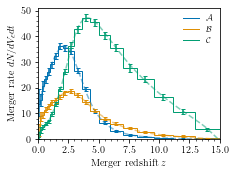

In [126]:
for j, key in enumerate(["pop1", "pop2", "pop3"]):
    
    plt.plot(z_grid, true_params[key]["merger_rate_grid"], color = true_params[key]["color"], ls = '--', alpha = 0.5)
    
    observed[key]["merger_rate_histogram_draws"] = rate_from_probz(zbins[0:-1], observed[key]["dNdz_draws"], zhigh = zbins[1:]) / true_params[key]["Tobs"]

    ymed = np.median(observed[key]["merger_rate_histogram_draws"], axis = 0)
    
    ylo = np.percentile(observed[key]["merger_rate_histogram_draws"], 5, axis = 0)
    
    yup = np.percentile(observed[key]["merger_rate_histogram_draws"], 95, axis = 0)
    
    fractional_width = (yup - ylo)/ymed
    
    observed[key]["merger_rate_histogram_fractional_width"] = fractional_width
    
    plt.stairs(ymed, zbins, color = true_params[key]["color"], label = true_params[key]["label"])
    
    plt.errorbar(zbin_centers, ymed, yerr = (ymed - ylo, yup - ymed), ls = "None", capsize = 2)
    
    #for i in range(nhist_draws):
    
    #    plt.stairs(observed[key]["merger_rate_histogram_draws"][i,:], zbins, color = colors[j], alpha = 0.05)

plt.xlim(0,ZMAX)

plt.legend(loc = 'best')

plt.xlabel(r'Merger redshift $z$')
plt.ylabel(r'Merger rate $dN/dV_c dt$')

plt.tight_layout()
#plt.savefig("Figures/dNdvcdt_3subpop.pdf")

plt.show()

0.06214220100773596
0.08792338841238051
0.05710409149851362


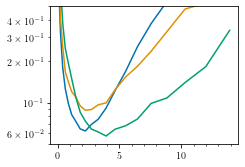

In [134]:
for j, key in enumerate(["pop1", "pop2", "pop3"]):

    plt.plot(zbin_centers, observed[key]["merger_rate_histogram_fractional_width"])
    
    print(min(observed[key]["merger_rate_histogram_fractional_width"]))
    
plt.ylim(0.05,0.5)
plt.yscale('log')


In [27]:
for key in ["pop1", "pop2", "pop3"]:
    
    merger_rate_histogram_draws_r = observed[key]["merger_rate_histogram_draws"][:,::-1]
    
    merger_rate_from_histogram_interp = interp1d(age_bin_centers_Gyr, merger_rate_histogram_draws_r, axis = -1, bounds_error = False, fill_value = (0,merger_rate_histogram_draws_r[:,-1]))(merger_time_grid)
    #merger_rate_from_histogram_interp = interp1d(age_bin_centers_Gyr, merger_rate_histogram_draws_r, axis = -1, bounds_error = False, fill_value = "extrapolate")(merger_time_grid)

    
    Ptau_grid_perf = true_params[key]["ptau_grid"] * (tau_grid[1] - tau_grid[0])
    Ptau_grid_marg = true_params[key]["ptau_grid_prior"] * (tau_grid[1] - tau_grid[0])
    
    observed[key]["formation_rate_grid"] = formation_from_merger_rate_v_age(merger_rate_from_histogram_interp.T, tau_grid, Ptau_grid_perf)
    observed[key]["formation_rate_grid_marg"] = formation_from_merger_rate_v_age(merger_rate_from_histogram_interp.T, tau_grid, Ptau_grid_marg)

In [28]:
max(age_bin_centers_Gyr)

DeviceArray(12.81389498, dtype=float64)

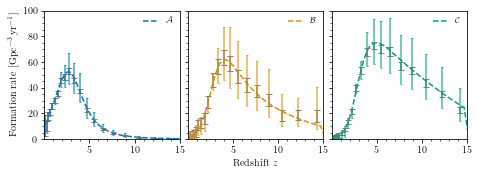

In [29]:
zform_grid = redshift_at_age_Gyr(tau_grid - tau_grid[0])
zform_bin_centers = redshift_at_age_Gyr(age_bin_centers_Gyr - tau_grid[0])

fig, ax = plt.subplots(nrows = 1, ncols = 3, sharex = True, sharey = True, figsize = (3.375 * 2,2.531))

for i, key in enumerate(['pop1', 'pop2', 'pop3']):

    ax[i].plot(zform_grid, true_params[key]["formation_rate_at_age"](tau_grid - tau_grid[0]), color = true_params[key]["color"], label = true_params[key]["label"], ls = '--')

    formation_rate_interp = interp1d(tau_grid - tau_grid[0], observed[key]["formation_rate_grid"], axis = 0)(age_bin_centers_Gyr - tau_grid[0])
    
    formation_rate_marg_interp = interp1d(tau_grid - tau_grid[0], observed[key]["formation_rate_grid_marg"], axis = 0)(age_bin_centers_Gyr - tau_grid[0])

    ymed = np.median(formation_rate_interp, axis = 1)
    
    ylo = np.percentile(formation_rate_interp, 5, axis = 1)
    
    yup = np.percentile(formation_rate_interp, 95, axis = 1)
    
    ymed_marg = np.median(formation_rate_marg_interp, axis = 1)
    
    ylo_marg = np.percentile(formation_rate_marg_interp, 5, axis = 1)
    
    yup_marg = np.percentile(formation_rate_marg_interp, 95, axis = 1)

    ax[i].errorbar(zform_bin_centers, ymed,  yerr = (ymed - ylo, yup - ymed), ls = "None", capsize = 3, color = 'gray')
    
    ax[i].errorbar(zform_bin_centers, ymed_marg,  yerr = (ymed_marg - ylo_marg, yup_marg - ymed_marg), ls = "None", capsize = 1, alpha = 0.7, color = true_params[key]["color"])

    ax[i].legend(loc = 'best')
    
    observed[key]["formation_rate_bin_centers"] = formation_rate_interp
    observed[key]["formation_rate_bin_centers_marg"] = formation_rate_marg_interp
    
plt.subplots_adjust(wspace = 0)   
plt.xlim(min(zform_grid), ZMAX)
plt.ylim(0,100)

ax[1].set_xlabel(r'Redshift $z$')
ax[0].set_ylabel(r'Formation rate $[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]$')

plt.tight_layout(w_pad = 0)

plt.savefig('Figures/inferred_formation_rate_v_redshift_3subpops.pdf', bbox_inches = "tight")
plt.show()
    

0.08831909858460307 2.74275666565407
[3.94561724 3.30202033 2.74275667 2.25659902 1.83387388]
0.14169662417345755 1.4662297592312055
[0.42973422 0.35924575 0.31826433 0.23818408]


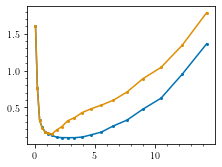

In [58]:
sfr_90perrors = np.percentile(observed["pop1"]["formation_rate_bin_centers"], 95, axis = 1) - np.percentile(observed["pop1"]["formation_rate_bin_centers"], 5, axis = 1)
sfr_relativeerrors = sfr_90perrors / np.percentile(observed["pop1"]["formation_rate_bin_centers"], 50, axis = 1)
plt.plot(zform_bin_centers, sfr_relativeerrors, marker = '.')

print(min(sfr_relativeerrors), zform_bin_centers[np.argmin(sfr_relativeerrors)])
print(zform_bin_centers[sfr_relativeerrors < 0.1])

sfr_90perrors = np.percentile(observed["pop1"]["formation_rate_bin_centers_marg"], 95, axis = 1) - np.percentile(observed["pop1"]["formation_rate_bin_centers"], 5, axis = 1)
sfr_relativeerrors = sfr_90perrors / np.percentile(observed["pop1"]["formation_rate_bin_centers_marg"], 50, axis = 1)
plt.plot(zform_bin_centers, sfr_relativeerrors, marker = '.')

print(min(sfr_relativeerrors), zform_bin_centers[np.argmin(sfr_relativeerrors)])
print(sfr_relativeerrors[np.array(zform_bin_centers < 4) & np.array(zform_bin_centers > 2)])

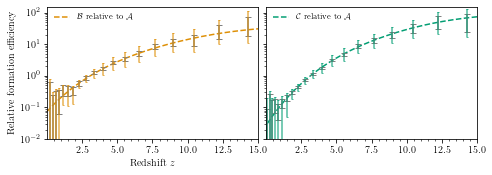

In [31]:
#efficiencies and then inference on metallicity distribution parameters

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True, figsize = (3.375 * 2,2.531))


for i, key in enumerate(["pop2", "pop3"]):
    observed[key]['efficiency_v_redshift'] = observed[key]['formation_rate_bin_centers'] / observed['pop1']['formation_rate_bin_centers']
    observed[key]['efficiency_v_redshift_marg'] = observed[key]['formation_rate_bin_centers_marg'] / observed['pop1']['formation_rate_bin_centers_marg']



    ax[i].plot(zform_grid, 1e6 * true_params[key]["efficiency_func"](zform_grid), color = true_params[key]["color"], label = true_params[key]["label"]+" relative to $\mathcal{A}$", ls = '--')
    
    ymed = np.median(observed[key]['efficiency_v_redshift'], axis = 1)
    
    ylo = np.percentile(observed[key]['efficiency_v_redshift'], 5, axis = 1)
    
    yup = np.percentile(observed[key]['efficiency_v_redshift'], 95, axis = 1)
    
    ax[i].errorbar(zform_bin_centers, ymed,  yerr = (ymed - ylo, yup - ymed), ls = "None", capsize = 3, color = 'gray')

    ymed_marg = np.median(observed[key]['efficiency_v_redshift_marg'], axis = 1)
    
    ylo_marg = np.percentile(observed[key]['efficiency_v_redshift_marg'], 5, axis = 1)
    
    yup_marg = np.percentile(observed[key]['efficiency_v_redshift_marg'], 95, axis = 1)
    
    ax[i].errorbar(zform_bin_centers, ymed_marg,  yerr = (ymed_marg - ylo_marg, yup_marg - ymed_marg), ls = "None", capsize = 1, alpha = 0.7, color = true_params[key]["color"])

    ax[i].legend(loc = 'best')

ax[0].set_xlabel(r'Redshift $z$')
ax[0].set_ylabel(r'Relative formation efficiency')

plt.tight_layout(w_pad = 0.5)
plt.ylim(0.01, 150)
plt.yscale('log')
plt.xlim(min(zform_grid), ZMAX)

plt.savefig('Figures/relative_formation_efficiency_pop2-3.pdf', bbox_inches = "tight")



plt.show()

#### Fit for metallicity distribution parameters

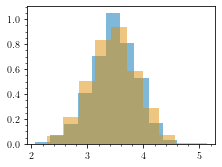

In [32]:
#check that at each point, inferred efficiency is roughly log-normal
plt.hist(np.log(observed['pop3']['efficiency_v_redshift_marg'][2,:]), density = True, alpha = 0.5)
plt.hist(np.mean(np.log(observed['pop3']['efficiency_v_redshift_marg'][2,:])) +  np.std(np.log(observed['pop3']['efficiency_v_redshift_marg'][2,:])) * np.random.randn(800), alpha = 0.5, density = True)
plt.show()

In [32]:
for pop in ["pop2", "pop3"]:
    for key in ["efficiency_v_redshift", "efficiency_v_redshift_marg"]:
        
        x = np.where(observed[pop][key] > 0, observed[pop][key], 1e-2) 
        
        x = np.log(x)
        
        observed[pop]["mean_log"+key] = np.mean(x, axis = -1)
        observed[pop]["std_log"+key] = np.std(x, axis = -1)

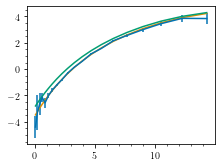

In [33]:
plt.errorbar(zform_bin_centers, observed["pop3"]["mean_logefficiency_v_redshift"], yerr= observed["pop3"]["std_logefficiency_v_redshift"])

plt.plot(zform_bin_centers, np.log(1e6 * efficiency_versus_redshift(zform_bin_centers, np.linspace(-5, 1, 512), 8e-5, -1, -1.778, 0.025, -0.049, 1.122, 0.049)))
        
plt.plot(zform_bin_centers, np.log(1e6 * efficiency_versus_redshift(zform_bin_centers, np.linspace(-5, 1, 512), 8e-5, -1, -1.778, 0.025, -0.049, 1.2, 0.049)))

In [62]:
zg = np.linspace(0, ZMAX, 50) #don't need as high resolution as z_grid


def calculate_metallicity_v_redshift_percentiles(mu0s, muzs, omega0s, omegazs):
    
    nsamp = 400 #don't need to use all the samples
    
    log10Z = np.linspace(-5, 1, 512)
    lnZ = np.log(10**log10Z * ZSUN)
    
    log10Z_ps = np.zeros((len(zg), nsamp, 5))
    
    for j in range(nsamp): #iterate over posterior samples
        
        pdflnZ = p_logZ_versus_redshift(log10Z, zg, -1.778, mu0s[j], muzs[j], omega0s[j], omegazs[j])

        for i, z in enumerate(zg): #iterate over redshifts
        
            log10Z_ps[i,j,:] = interp1d(cumtrapz(pdflnZ, lnZ, axis = -1, initial = 0)[i,:], log10Z)(np.array([0.05, 0.25, 0.5, 0.75, 0.95]))
        
    return log10Z_ps

In [63]:
true_metallicity_dist_params = [ -1.778, 0.025, -0.049, 1.122, 0.049] 
true_eff_params = [8e-5, -1, 3e-5, -0.7]

In [36]:
def model_onepop(observed_mean, observed_std, yp = 8e-5, wm1p = -1, perf = True):
    
    #priors on efficiency versus metallicity
    if perf:
        y = numpyro.deterministic("y", yp)
        wm1 = numpyro.deterministic("wm1", wm1p)
        
    else:
        logy = numpyro.sample("logy", dist.Normal(jnp.log(yp), 0.5))
        y = numpyro.deterministic("y", jnp.exp(logy))
        wm1 = numpyro.sample("wm1", dist.Normal(wm1p, 0.1))
    
    #priors on metallicity distribution as a function of redshift, take from van Son et al. Table 2
    
    #alpha = numpyro.sample("alpha", dist.Uniform(-6, 0))
    alpha = numpyro.deterministic("alpha", true_metallicity_dist_params[0])
        
    mu0 = numpyro.sample("mu0", dist.Uniform(0.007, 0.035))
    
    muz = numpyro.sample("muz", dist.Uniform(-0.5, 0))
    
    omega0 = numpyro.sample("omega0", dist.Uniform(0.7, 2))  
    #omega0 = numpyro.deterministic("omega0", true_metallicity_dist_params[-2])
    
    omegaz = numpyro.sample("omegaz", dist.Uniform(0, 0.1))
    #omegaz = numpyro.deterministic("omegaz", true_metallicity_dist_params[-1])

    
    ef = 1e6 * efficiency_versus_redshift(zform_bin_centers, np.linspace(-5, 1, 512), y, wm1, alpha, mu0, muz, omega0, omegaz)
    
    #ef = jnp.where(jnp.isnan(ef), 1e12, ef) #set nans to some really big number
                   
    efficiency_versus_redshift_vals = numpyro.deterministic("efficiency_versus_redshift_vals", ef)

    numpyro.sample("logeff", dist.Normal(jnp.log(efficiency_versus_redshift_vals), observed_std), obs = observed_mean)
    
    
def model_twopop(observed_mean1, observed_std1, observed_mean2, observed_std2, yp1 = 8e-5, wm1p1 = -1, yp2 = 3e-5 , wm1p2 = -0.7, perf = True):
        
        
    #priors on efficiency versus metallicity
    if perf:
        y1 = numpyro.deterministic("y1", yp1)
        wm11 = numpyro.deterministic("wm11", wm1p1)
        y2 = numpyro.deterministic("y2", yp2)
        wm12 = numpyro.deterministic("wm12", wm1p2)      
        
    else:
        logy1 = numpyro.sample("logy1", dist.Normal(jnp.log(yp1), 0.5))
        y1 = numpyro.deterministic("y1", jnp.exp(logy1))
        wm11 = numpyro.sample("wm11", dist.Normal(wm1p1, 0.1))
        
        logy2 = numpyro.sample("logy2", dist.Normal(jnp.log(yp2), 0.5))
        y2 = numpyro.deterministic("y2", jnp.exp(logy2))
        wm12 = numpyro.sample("wm12", dist.Normal(wm1p2, 0.1))
        
    #priors on metallicity distribution
#    alpha = numpyro.sample("alpha", dist.Uniform(-6, 0))
    alpha = numpyro.deterministic("alpha", true_metallicity_dist_params[0])
        
    mu0 = numpyro.sample("mu0", dist.Uniform(0.007, 0.035))
    
    muz = numpyro.sample("muz", dist.Uniform(-0.5, 0))
    
    omega0 = numpyro.sample("omega0", dist.Uniform(0.7, 2))
    
    omegaz = numpyro.sample("omegaz", dist.Uniform(0, 0.1))
    
    ef1 = 1e6 * efficiency_versus_redshift(zform_bin_centers, np.linspace(-5, 1, 512), y1, wm11, alpha, mu0, muz, omega0, omegaz)

    ef2 = 1e6 * efficiency_versus_redshift(zform_bin_centers, np.linspace(-5, 1, 512), y2, wm12, alpha, mu0, muz, omega0, omegaz)

    efficiency_versus_redshift_vals1 = numpyro.deterministic("efficiency_versus_redshift_vals1", ef1)
    efficiency_versus_redshift_vals2 = numpyro.deterministic("efficiency_versus_redshift_vals2", ef2)

    numpyro.sample("logeff1", dist.Normal(jnp.log(efficiency_versus_redshift_vals1), observed_std1), obs = observed_mean1)

    numpyro.sample("logeff2", dist.Normal(jnp.log(efficiency_versus_redshift_vals2), observed_std2), obs = observed_mean2)




In [37]:
jax.local_device_count()

2

In [38]:
sampler = infer.MCMC(
    infer.NUTS(model_onepop),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(0), observed["pop2"]["mean_logefficiency_v_redshift"], observed["pop2"]["std_logefficiency_v_redshift"],
            true_eff_params[2], true_eff_params[3],
            perf = True)

inference_pop2_perf = az.from_numpyro(sampler)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [42]:
az.to_netcdf(inference_pop2_perf, "Inference/inference_pop2_perf.netcdf")

'Inference/inference_pop2_perf.netcdf'

In [45]:
inference_pop2_perf = az.from_netcdf("Inference/inference_pop2_perf.netcdf")

In [46]:
sampler.run(jax.random.PRNGKey(0), observed["pop3"]["mean_logefficiency_v_redshift"], observed["pop3"]["std_logefficiency_v_redshift"],
            true_eff_params[0], true_eff_params[1],
            perf = True)

inference_pop3_perf = az.from_numpyro(sampler)
az.to_netcdf(inference_pop3_perf, "Inference/inference_pop3_perf.netcdf")

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

'Inference/inference_pop3_perf.netcdf'

In [47]:
sampler = infer.MCMC(
    infer.NUTS(model_twopop),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(0), observed["pop3"]["mean_logefficiency_v_redshift"], observed["pop3"]["std_logefficiency_v_redshift"],
            observed["pop2"]["mean_logefficiency_v_redshift"], observed["pop2"]["std_logefficiency_v_redshift"],
            perf = True)

inference_twopop_perf = az.from_numpyro(sampler)
az.to_netcdf(inference_twopop_perf, "Inference/inference_twopop_perf.netcdf")

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

'Inference/inference_twopop_perf.netcdf'

In [50]:
sampler = infer.MCMC(
    infer.NUTS(model_twopop),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(0), observed["pop3"]["mean_logefficiency_v_redshift_marg"], observed["pop3"]["std_logefficiency_v_redshift_marg"],
            observed["pop2"]["mean_logefficiency_v_redshift_marg"], observed["pop2"]["std_logefficiency_v_redshift_marg"],
            perf = False)

inference_twopop_marg = az.from_numpyro(sampler)
az.to_netcdf(inference_twopop_marg, "Inference/inference_twopop_marg.netcdf")

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

'Inference/inference_twopop_marg.netcdf'

#### read in data here if don't want to rerun sampler

In [59]:
inference_pop2_perf = az.from_netcdf("Inference/inference_pop2_perf.netcdf")
inference_pop3_perf = az.from_netcdf("Inference/inference_pop3_perf.netcdf")
inference_twopop_perf = az.from_netcdf("Inference/inference_twopop_perf.netcdf")
inference_twopop_marg = az.from_netcdf("Inference/inference_twopop_marg.netcdf")

In [113]:
az.summary(inference_twopop_perf, 
           stat_funcs =  {"5%": lambda x: np.percentile(x, 5), 
                          "median": lambda x: np.percentile(x, 50),
                          "95%": lambda x: np.percentile(x, 95),
                         "90% credibility width": lambda x: np.percentile(x,95) - np.percentile(x, 5)},
           var_names = ["mu0", "muz", "omega0", "omegaz"], 
          extend = False)

,5%,median,95%,90% credibility width
mu0,0.020,0.028,0.034,0.014
muz,-0.112,-0.074,-0.038,0.074
omega0,1.057,1.162,1.233,0.176
omegaz,0.030,0.042,0.052,0.022


In [114]:
az.summary(inference_twopop_marg, 
           stat_funcs =  {"5%": lambda x: np.percentile(x, 5), 
                          "median": lambda x: np.percentile(x, 50),
                          "95%": lambda x: np.percentile(x, 95),
                         "90% credibility width": lambda x: np.percentile(x,95) - np.percentile(x, 5)},
           var_names = ["mu0", "muz", "omega0", "omegaz"], 
          extend = False)

,5%,median,95%,90% credibility width
mu0,0.012,0.024,0.034,0.022
muz,-0.160,-0.088,-0.022,0.137
omega0,0.806,1.088,1.281,0.475
omegaz,0.015,0.043,0.066,0.051


In [115]:
az.summary(inference_pop2_perf, 
           stat_funcs =  {"5%": lambda x: np.percentile(x, 5), 
                          "median": lambda x: np.percentile(x, 50),
                          "95%": lambda x: np.percentile(x, 95),
                         "90% credibility width": lambda x: np.percentile(x,95) - np.percentile(x, 5)},
           var_names = ["mu0", "muz", "omega0", "omegaz"], 
          extend = False)

,5%,median,95%,90% credibility width
mu0,0.012,0.024,0.034,0.022
muz,-0.135,-0.068,-0.018,0.116
omega0,0.780,1.091,1.255,0.476
omegaz,0.012,0.045,0.062,0.050


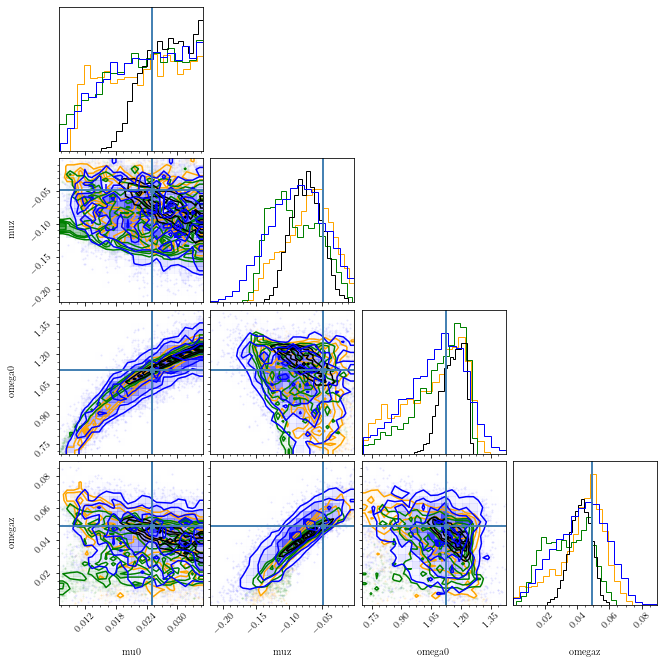

In [52]:
fig = corner.corner(inference_pop2_perf, var_names = ["mu0", "muz", "omega0", "omegaz"], truths = true_metallicity_dist_params[1:5], color = 'orange');
corner.corner(inference_pop3_perf, var_names = ["mu0", "muz", "omega0", "omegaz"], truths = true_metallicity_dist_params[1:5], fig = fig, color = 'green');
corner.corner(inference_twopop_perf, var_names = ["mu0", "muz", "omega0", "omegaz"], truths = true_metallicity_dist_params[1:5], fig = fig);
corner.corner(inference_twopop_marg, var_names = ["mu0", "muz", "omega0", "omegaz"], truths = true_metallicity_dist_params[1:5], fig = fig, color = "blue");

In [60]:
#indexing for percentiles: 0 is 5th percentile, 2 is 50th percentile, 4 (or -1) is 95th percentile
def make_metallicity_v_redshift_inference_plot(inference, ax, legend = True, axlabel = True):
    
    mu0s, muzs, omega0s, omegazs = inference["posterior"]["mu0"][0], inference["posterior"]["muz"][0], inference["posterior"]["omega0"][0], inference["posterior"]["omegaz"][0]

    mu0s, muzs, omega0s, omegazs = mu0s.to_numpy(), muzs.to_numpy(), omega0s.to_numpy(), omegazs.to_numpy()

    ps = calculate_metallicity_v_redshift_percentiles(mu0s, muzs, omega0s, omegazs)
    

    ax.plot(zg, np.median(ps[:,:,-1],axis = -1), label = '95th percentile', color = sns.color_palette("rocket")[-1])
    ax.fill_between(zg, np.percentile(ps[:,:,-1], 5, axis = -1), np.percentile(ps[:,:,-1], 95, axis = -1), alpha = 0.5, color = sns.color_palette("rocket")[-1] )

    ax.plot(zg, np.median(ps[:,:,2],axis = -1), label = 'Median', color = sns.color_palette("rocket")[1])
    ax.fill_between(zg, np.percentile(ps[:,:,2], 5, axis = -1), np.percentile(ps[:,:,2], 95, axis = -1), alpha = 0.5, color = sns.color_palette("rocket")[1] )


    ax.plot(zg, np.median(ps[:,:,0],axis = -1), label = '5th percentile', color = sns.color_palette("rocket")[-2])
    ax.fill_between(zg, np.percentile(ps[:,:,0], 5, axis = -1), np.percentile(ps[:,:,0], 95, axis = -1), alpha = 0.5, color = sns.color_palette("rocket")[-2] )


    ax.plot(zplot, log10Z_ps[:,0], ls = '--', c = 'k', alpha = 0.5)
    ax.plot(zplot, log10Z_ps[:,4], ls = '--', c = 'k', alpha = 0.5)
    ax.plot(zplot, log10Z_ps[:,2], ls = '--', c = 'k', alpha = 0.5)
    
    ax.set_xlim(0,ZMAX)
    
    if legend:
        ax.legend(loc = 'best')
        
    if axlabel:

        ax.set_xlabel(r'Redshift $z$')
        ax.set_ylabel(r'$\log_{10} Z/Z_\odot$')
    
    return ps


Note that that the 95th percentile is kind of biased but that's because the truth is on the upper edge of the prior boundaries for omega_0 and omega_z, so there is more prior volume for narrower distributions? Also we don't expect to constrain high end well unless we have prior constraints on the shape.

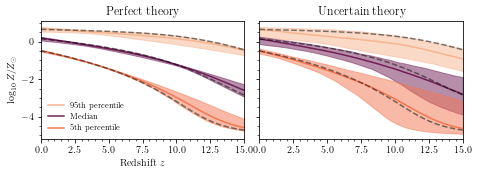

In [59]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True, figsize = (3.375 * 2,2.531))

make_metallicity_v_redshift_inference_plot(inference_twopop_perf, ax[0], legend = True, axlabel = True)
make_metallicity_v_redshift_inference_plot(inference_twopop_marg, ax[1], legend = False, axlabel = False)

ax[0].set_title("Perfect theory")
ax[1].set_title("Uncertain theory")

plt.subplots_adjust(wspace = 0)
plt.tight_layout(w_pad = 0)

#plt.savefig('Figures/inferred_metallicity_v_redshift_twopop_perf_marg.pdf', bbox_inches = "tight")

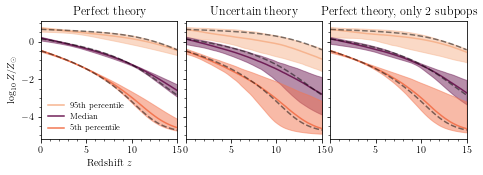

In [64]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, sharex = True, sharey = True, figsize = (3.375 * 2,2.531))

ps_all_perf = make_metallicity_v_redshift_inference_plot(inference_twopop_perf, ax[0], legend = True, axlabel = True)
ps_all_marg = make_metallicity_v_redshift_inference_plot(inference_twopop_marg, ax[1], legend = False, axlabel = False)
ps_all_only2 = make_metallicity_v_redshift_inference_plot(inference_pop2_perf, ax[2], legend = False, axlabel = False)

ax[0].set_title("Perfect theory")
ax[1].set_title("Uncertain theory")
ax[2].set_title("Perfect theory, only 2 subpops")


plt.subplots_adjust(wspace = 0)   

plt.tight_layout(w_pad = 0)

#plt.savefig('Figures/inferred_metallicity_v_redshift_perf_marg_only2.pdf', bbox_inches = "tight")

maximum uncertainty on median for z below 10 (in dex):  0.36766727738712374
maximum uncertainty on median (in dex):  1.3002110334905983
maximum relative uncertainty on width:  0.7547388926947182
relative uncertainty on difference between median at z15 to z0:  0.4817620681764923



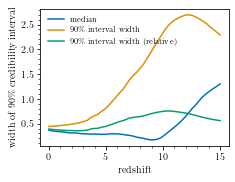

In [124]:
#width of 90% credibility interval

#p_compare = ps_all_perf
#p_compare = ps_all_marg
p_compare = ps_all_only2

med = np.percentile(p_compare[:,:,2], 95, axis = -1) -  np.percentile(p_compare[:,:,2], 5, axis = -1)
plt.plot(zg, med, label = 'median')

diff_between_medZ_z15_z0 = p_compare[0,:,2] - p_compare[-1,:,2]
diff_between_med_rel = (np.percentile(diff_between_medZ_z15_z0, 95) - np.percentile(diff_between_medZ_z15_z0, 5))/ np.percentile(diff_between_medZ_z15_z0, 50)



w90 = np.percentile(p_compare[:,:,-1] - p_compare[:,:,0], 95, axis = -1) -  np.percentile(p_compare[:,:,-1] - p_compare[:,:,0], 5, axis = -1)
relw90 = w90 / np.percentile(p_compare[:,:,-1] - p_compare[:,:,0], 50, axis = -1)
plt.plot(zg, w90, label = '90\% interval width')
plt.plot(zg, relw90, label = '90\% interval width (relative)')



plt.legend(loc = 'best')

plt.xlabel('redshift')
plt.ylabel('width of 90\% credibility interval')

#print(max(zg[med < 0.2]))
#print(max(zg[med < 0.5]))
print("maximum uncertainty on median for z below 10 (in dex): ", max(med[zg < 10]))
print("maximum uncertainty on median (in dex): ", max(med))

print("maximum relative uncertainty on width: ", max(relw90))

print("relative uncertainty on difference between median at z15 to z0: ", diff_between_med_rel)



print()

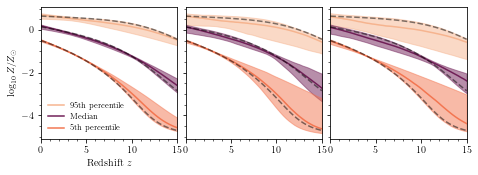

In [61]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, sharex = True, sharey = True, figsize = (3.375 * 2,2.531))

make_metallicity_v_redshift_inference_plot(inference_twopop_perf, ax[0], legend = True, axlabel = True)
make_metallicity_v_redshift_inference_plot(inference_pop2_perf, ax[1], legend = False, axlabel = False)
make_metallicity_v_redshift_inference_plot(inference_pop3_perf, ax[2], legend = False, axlabel = False)
plt.subplots_adjust(wspace = 0)   

plt.tight_layout(w_pad = 0)

plt.savefig('Figures/inferred_metallicity_v_redshift_pop2_3_both.pdf', bbox_inches = "tight")

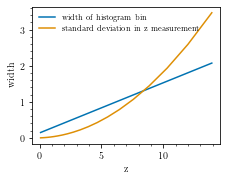

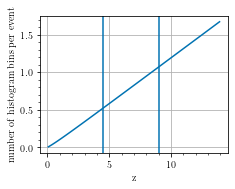

In [36]:

sigmaz = (0.017 * zbin_centers + 0.012) * zbin_centers

plt.plot(zbin_centers, zbin_width, label = 'width of histogram bin')
plt.plot(zbin_centers, sigmaz, label = 'standard deviation in z measurement')

plt.xlabel('z')
plt.ylabel('width')

plt.legend(loc = 'best')
plt.show()

plt.plot(zbin_centers, sigmaz/ zbin_width)
plt.xlabel('z')
plt.ylabel('number of histogram bins per event')

plt.grid()

plt.axvline(4.5)
plt.axvline(9)

plt.show()


0.9397777777777778
0.9976666666666667
0.8514545454545455
0.9884545454545455
0.620875
0.9467083333333334


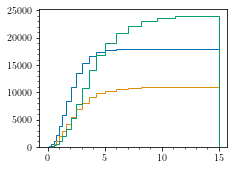

In [42]:
for j, key in enumerate(["pop1", "pop2", "pop3"]):
    
        
    plt.hist(observed[key]["zs"], bins = zbins, histtype = 'step', cumulative = True)
    
    print(sum(observed[key]["zs"] < 4.5) / sum(observed[key]["zs"] < 15))
    
    print(sum(observed[key]["zs"] < 9) / sum(observed[key]["zs"] < 15))